In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams["text.usetex"] = True

### Parametric models

In several applications, we are interested in the determination of the parameters involved in the modeling of the SED, for instance, the age or the metallicity of a stellar population model that better describes some observations. The `NonParametricModel`class above can be used for that purpose, of course, but the problem of determining the correct weights becomes more difficult as we include more templates, and each computational operations requires handling . One alternative is thus to interpolate the models, such that we can access to all models in a library, but we just instanciate the model at each necessary interaction using a very limited number of models, but which we can instanciate . In this case, we can use the `ParametricModel` class. In the example below, we use a set of theoretical stellar models from [Coelho (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.440.1027C/abstract), which you can download [here](http://specmodels.iag.usp.br/) to demonstrate how to use this class.

Model allowed ranges
{'T': (3000.0, 26000.0), 'g': (-0.5, 5.5), 'Z': (-1.3, 0.2), 'alpha': (0.0, 0.4)}
List of parameters of model
['T', 'g', 'Z', 'alpha']


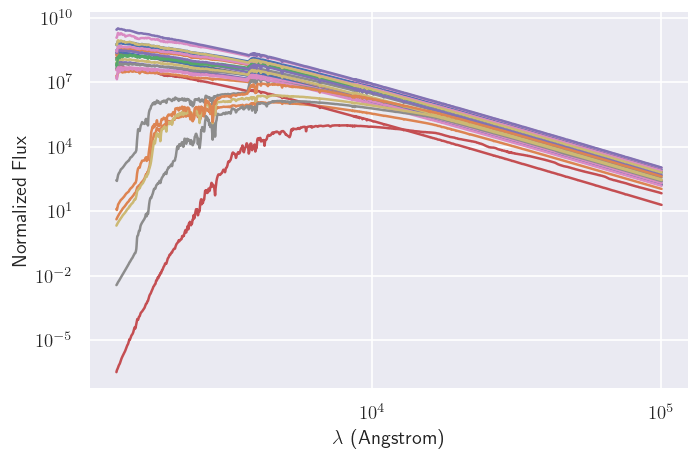

In [4]:
import os
import numpy as np
import astropy.units as u
from astropy.modeling import models
from astropy.io import fits
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import paintbox as pb
from paintbox import utils
from ppxf import ppxf_util, miles_util

def load_Coelho2014():
    """ Read all models from Coelho+(2014) stored in a local directory"""
    models_dir = "s_coelho14_sed"
    model_names = [_ for _ in os.listdir(models_dir) if _.endswith(".fits")]
    # Get dispersion from the header of a file
    filename = os.path.join(models_dir, model_names[0])
    crval1 = fits.getval(filename, "CRVAL1")
    cdelt1 = fits.getval(filename, "CDELT1")
    n = fits.getval(filename, "NAXIS1")
    pix = np.arange(n) + 1
    wave = np.power(10, crval1 + cdelt1 * pix) * u.micrometer
    # Create an table with parameters based on the file names
    table = []
    # Also store all templates into a 2D array
    templates = np.zeros((len(model_names), n))
    for i, filename in enumerate(model_names):
        T = float(filename.split("_")[0][1:])
        g = float(filename.split("_")[1][1:])
        Z = 0.1 * float(filename.split("_")[2][:3].replace(
            "m", "-").replace("p", "+"))
        alpha = 0.1 * float(filename.split("_")[2][3:].replace(
            "m", "-").replace("p", "+"))
        a = np.array([T, g, Z, alpha])
        t = Table(a, names=["T", "g", "Z", "alpha"])
        table.append(t)
        templates[i] = fits.getdata(os.path.join(models_dir, filename))
    table = vstack(table) # Join all tables in one
    return wave, table, templates

wave, table, templates = load_Coelho2014()
star = pb.ParametricModel(wave, table, templates)
# Plotting n random models
fig = plt.figure(dpi=120)
n = 50
print("Model allowed ranges")
print(star.limits)
print("List of parameters of model")
print(star.parnames)
for i in range(n):
    theta = np.array([np.random.uniform(star.limits[p][0], star.limits[p][1]) 
                          for p in star.parnames])
    star.plot(theta, plottype="loglog")
plt.xlabel("$\lambda$ (Angstrom)")
plt.ylabel("Normalized Flux")
plt.tight_layout()
plt.savefig("../docs/figures/interpolated_star.png")

The above code illustrates how to *prepare* the data for `paintbox`ingestion for a particular case, but we notice that the `ParametricModel` class require only three arguments, the wevelength array (one for each spectral element), an `astropy.table.Table` object that contains the parameters of the model, and a 2D `numpy.ndarray` with the correspondent models for each table row. There is no single standard of distribution for model files, and such preliminary preprocessing is often necessary. However, for a few popular stellar population models, there are utility classes distributed with `paintbox` that already perform this task and provide production-ready classes. Please check the building_models tutorial and documentation for more details. 